In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error,SCORERS
from sklearn.model_selection import cross_val_score


from sklearn.preprocessing import LabelEncoder

# Models
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm 
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

import xgboost as xgb


#To export the model
import pickle


!ls

__notebook__.ipynb


In [2]:
np.random.seed(30)

In [3]:
df = pd.read_csv('/kaggle/input/nyc-rolling-data.csv')

In [4]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,376,43,NaN,S1,743 EAST 6TH STREET,NaN,...,1.0,1.0,2.0,2090.0,3680.0,1940.0,1,S1,3200000,2019-07-24 00:00:00
1,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,390,61,NaN,A4,189 EAST 7TH STREET,NaN,...,1.0,0.0,1.0,987.0,2183.0,1860.0,1,A4,0,2019-09-25 00:00:00
2,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,404,1,NaN,B9,166 AVENUE A,NaN,...,2.0,0.0,2.0,1510.0,4520.0,1900.0,1,B9,0,2019-07-22 00:00:00
3,1,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,377,56,NaN,C0,263 EAST 7TH STREET,NaN,...,3.0,0.0,3.0,2430.0,3600.0,1899.0,1,C0,6300000,2019-04-30 00:00:00
4,1,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,393,9,NaN,C0,604 EAST 11TH STREET,NaN,...,3.0,0.0,3.0,2375.0,5110.0,1939.0,1,C0,0,2019-10-24 00:00:00


In [5]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object')

# Data Cleaning/Validation

In [6]:
# change building class to type int
df['BUILDING CLASS CATEGORY']=df['BUILDING CLASS CATEGORY'].str[0:2]
df['BUILDING CLASS CATEGORY']=df['BUILDING CLASS CATEGORY'].astype(int)

#drop easement 100% Nan ,Apartment Number 70% Nan and Address is too specific probably wont generalize
df.drop(columns=['EASE-MENT','APARTMENT NUMBER','ADDRESS'], inplace=True)

# Drop properties that were transfered without cash consideration
df=df[df['SALE PRICE']!=0]

# Deal with NaN
df.fillna(-1,inplace=True)

In [7]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,1,1,376,43,S1,10009.0,1.0,1.0,2.0,2090.0,3680.0,1940.0,1,S1,3200000,2019-07-24 00:00:00
3,1,ALPHABET CITY,3,1,377,56,C0,10009.0,3.0,0.0,3.0,2430.0,3600.0,1899.0,1,C0,6300000,2019-04-30 00:00:00
5,1,ALPHABET CITY,7,2,372,23,C1,10009.0,12.0,0.0,12.0,2393.0,7989.0,2001.0,2,C1,1950000,2019-08-08 00:00:00
7,1,ALPHABET CITY,7,2A,376,23,C3,10009.0,4.0,0.0,4.0,2059.0,4154.0,1900.0,2,C3,600000,2019-12-12 00:00:00
8,1,ALPHABET CITY,7,2A,376,26,C3,10009.0,4.0,0.0,4.0,2065.0,3491.0,1900.0,2,C3,4350000,2019-10-31 00:00:00


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56741 entries, 0 to 81482
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         56741 non-null  int64  
 1   NEIGHBORHOOD                    56741 non-null  object 
 2   BUILDING CLASS CATEGORY         56741 non-null  int64  
 3   TAX CLASS AT PRESENT            56741 non-null  object 
 4   BLOCK                           56741 non-null  int64  
 5   LOT                             56741 non-null  int64  
 6   BUILDING CLASS AT PRESENT       56741 non-null  object 
 7   ZIP CODE                        56741 non-null  float64
 8   RESIDENTIAL UNITS               56741 non-null  float64
 9   COMMERCIAL UNITS                56741 non-null  float64
 10  TOTAL UNITS                     56741 non-null  float64
 11  LAND SQUARE FEET                56741 non-null  float64
 12  GROSS SQUARE FEET               

# Random Forrest Regressor

In [9]:
print(df.columns)

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'BUILDING CLASS AT PRESENT',
       'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object')


In [10]:
cat_names=['SALE DATE','BUILDING CLASS AT TIME OF SALE','ZIP CODE','BUILDING CLASS AT PRESENT','NEIGHBORHOOD']
cont_names=['TAX CLASS AT TIME OF SALE','YEAR BUILT','GROSS SQUARE FEET','LAND SQUARE FEET',
            'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS','BLOCK', 'LOT','TAX CLASS AT PRESENT','BOROUGH',  'BUILDING CLASS CATEGORY']
target='SALE PRICE'

## Baseline

In [11]:
X_train ,X_test, y_train, y_test = train_test_split(df.drop(columns=['SALE PRICE','SALE DATE','NEIGHBORHOOD','TAX CLASS AT PRESENT','BUILDING CLASS AT PRESENT',
                                                                     'BUILDING CLASS AT TIME OF SALE']),df['SALE PRICE'],test_size=0.2)

In [12]:
model_rf = RandomForestRegressor(random_state=0,n_jobs=4)
model_rf.fit(X_train,y_train)
predicted = model_rf.predict(X_test)
mean_absolute_error(y_test,predicted)

1173457.246346882

Feature ranking:
1. feature 2 (0.281490)
2. feature 9 (0.201380)
3. feature 3 (0.110341)
4. feature 4 (0.100834)
5. feature 8 (0.087557)
6. feature 10 (0.069185)
7. feature 6 (0.042251)
8. feature 7 (0.041844)
9. feature 1 (0.040229)
10. feature 0 (0.009720)
11. feature 11 (0.008345)
12. feature 5 (0.006823)


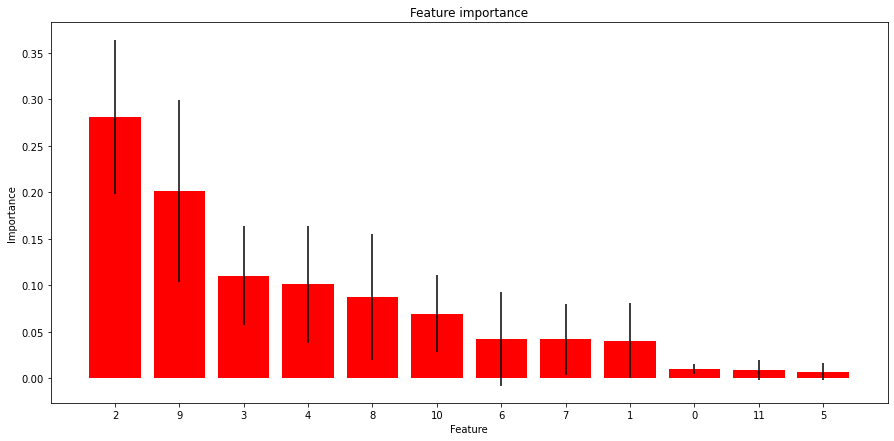

<Figure size 432x288 with 0 Axes>

In [13]:
#Plotting feature importance of the numeric features
importances = model_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(15,7))
plt.title("Feature importance")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()
plt.savefig('NumericalFeatures.png')


|Feature ranking|Feature number|Feature name|
|--------------|--------------|------------|
|1             |2             |Block       |
|2             |9             |Gross square feet|
|3             |3             |Lot         |
|4             |4             |Zipcode     |
|5             |8             |Land square feet|
|6             |10            |Year built|
|7             |6             |Commerical units|
|8             |7             |Total units|
|9             |1             |Building Class Category|
|10            |0             |Borough|
|11            |11            |Tax class at time of sale|
|12            |5             |Residential units| 

# Label Encoding

In [14]:

# label encoder for each cat variable so 5
neighborhood_encoder=LabelEncoder()
tax_class_present_encoder=LabelEncoder()
building_class_encoder=LabelEncoder()
building_class_at_sale_encoder=LabelEncoder()
sale_date_encode=LabelEncoder()
df['NEIGHBORHOOD'] = neighborhood_encoder.fit_transform(df['NEIGHBORHOOD'])
df['BUILDING CLASS AT TIME OF SALE']=building_class_at_sale_encoder.fit_transform(df['BUILDING CLASS AT TIME OF SALE'])
df['TAX CLASS AT PRESENT']=tax_class_present_encoder.fit_transform(df['TAX CLASS AT PRESENT'].astype(str))
df['BUILDING CLASS AT PRESENT']=building_class_encoder.fit_transform(df['BUILDING CLASS AT PRESENT'].astype(str))
df['SALE DATE']=sale_date_encode.fit_transform(df['SALE DATE'])

In [15]:


X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['SALE PRICE',]), df['SALE PRICE'], test_size=0.2)



In [16]:
model_rf = RandomForestRegressor(random_state=0,n_jobs=4)
model_rf.fit(X_train,y_train)
predicted = model_rf.predict(X_test)
mean_absolute_error(y_test,predicted)

1152266.7387596003

Feature ranking:
1. feature 4 (0.233278)
2. feature 5 (0.209924)
3. feature 16 (0.145600)
4. feature 12 (0.101051)
5. feature 7 (0.073133)
6. feature 13 (0.067797)
7. feature 11 (0.043133)
8. feature 9 (0.023006)
9. feature 1 (0.022404)
10. feature 10 (0.019857)
11. feature 2 (0.017563)
12. feature 15 (0.012383)
13. feature 8 (0.009258)
14. feature 6 (0.008899)
15. feature 14 (0.007283)
16. feature 0 (0.003048)
17. feature 3 (0.002383)


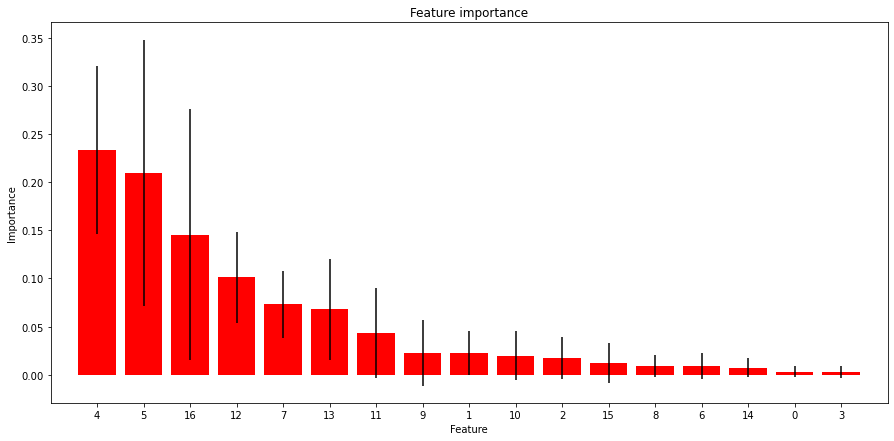

<Figure size 432x288 with 0 Axes>

In [17]:
#Plotting feature importance of the numeric features
importances = model_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(15,7))
plt.title("Feature importance")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()
plt.savefig('AllFeatures.png')

In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45392 entries, 68530 to 2571
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         45392 non-null  int64  
 1   NEIGHBORHOOD                    45392 non-null  int64  
 2   BUILDING CLASS CATEGORY         45392 non-null  int64  
 3   TAX CLASS AT PRESENT            45392 non-null  int64  
 4   BLOCK                           45392 non-null  int64  
 5   LOT                             45392 non-null  int64  
 6   BUILDING CLASS AT PRESENT       45392 non-null  int64  
 7   ZIP CODE                        45392 non-null  float64
 8   RESIDENTIAL UNITS               45392 non-null  float64
 9   COMMERCIAL UNITS                45392 non-null  float64
 10  TOTAL UNITS                     45392 non-null  float64
 11  LAND SQUARE FEET                45392 non-null  float64
 12  GROSS SQUARE FEET            

|Feature ranking|Feature number|Feature name| 
|--------------|--------------|------------| 
|1             |4             |Block       | 
|2             |12             |Gross square feet|
|3             |5             |Lot         | 
|4             |7             |Zipcode     |
|5             |16            |Sale Date|
|6             |11           |Land Square Feet|
|7             |13             |Year Built|
|8             |10             |Total units|
|9             |1             |Neighborhood|
|10            |2             |Building Class Category|
|11            |9            |Commercial units|
|12            |15             |Building class at time of sale|  
|13            |6            |Building class at present|
|14            | 0|Borough|
|15            |8|Residential Units|
|16            |14|Tax Class At Time of Sale|
|17            |3| Tax Class At Present|




# Using cross validation

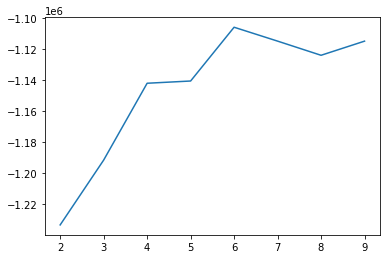

In [19]:
 
model_rf = RandomForestRegressor(random_state=0,n_jobs=4)
#model_rf.fit(X_train,y_train)
#predicted = model_rf.predict(X_train)
#mean_absolute_error(y_train,predicted)
error=[]
split=[]
for cv in range(2,10):
    split.append(cv)
    error.append(np.mean(cross_val_score(model_rf,X_train,y_train,cv=cv,scoring='neg_mean_absolute_error')))
plt.plot(split,error)


### Best cv at 7 folds gives roughly the same mae as the regular model

In [20]:
def smallest_error( list ):
    max = list[ 0 ]
    for a in list:
        if a > max:
            max = a
    return max
smallest_error(error)

-1106003.3802109847

# Ordinary least squares

In [21]:
x_sm = sm.add_constant(X_train)
model = sm.OLS(y_train,x_sm)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SALE PRICE   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     244.3
Date:                Fri, 05 Jun 2020   Prob (F-statistic):               0.00
Time:                        04:14:58   Log-Likelihood:            -8.1682e+05
No. Observations:               45392   AIC:                         1.634e+06
Df Residuals:                   45374   BIC:                         1.634e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           1.254e+07   1.93e+06      6.494      0.000    8.76e+06    1.63e+07
BOROUGH                        -6.097e+05   7.92e+04     -7.701      0.000   -7.65e+05   -4.55e+05
NEIGHBORHOOD                   -3533.3160   1056.455     -3.345      0.001   -5603.984   -1462.648
BUILDING CLASS CATEGORY         -5.91e+04   3.08e+04     -1.922      0.055   -1.19e+05    1179.344
TAX CLASS AT PRESENT           -7.275e+05   8.92e+04     -8.155      0.000   -9.02e+05   -5.53e+05
BLOCK                            -36.6064     26.092     -1.403      0.161     -87.747      14.534
LOT                             -735.4608    164.365     -4.475      0.000   -1057.619    -413.303
BUILDING CLASS AT PRESENT       1.045e+04   1.13e+04      0.922      0.357   -1.18e+04    3.27e+04
ZIP CODE                       -1017.9084    181.020     -5.623      0.000   -1372.711    -663.106
RESIDENTIAL UNITS               2.215e+06   2.47e+05      8.950      0.000    1.73e+06     2.7e+06
COMMERCIAL UNITS                1.994e+06   2.48e+05      8.026      0.000    1.51e+06    2.48e+06
TOTAL UNITS                    -1.984e+06   2.49e+05     -7.956      0.000   -2.47e+06    -1.5e+06
LAND SQUARE FEET                 -12.2703      0.624    -19.651      0.000     -13.494     -11.046
GROSS SQUARE FEET                 80.6443      3.040     26.529      0.000      74.686      86.602
YEAR BUILT                     -1758.1643    161.034    -10.918      0.000   -2073.794   -1442.534
TAX CLASS AT TIME OF SALE       5.991e+06   4.66e+05     12.863      0.000    5.08e+06     6.9e+06
BUILDING CLASS AT TIME OF SALE -1.197e+04    1.1e+04     -1.089      0.276   -3.35e+04    9570.359
SALE DATE                        716.9346    764.512      0.938      0.348    -781.520    2215.390
==============================================================================
Omnibus:                   159031.418   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     119355775722.616
Skew:                          67.862   Prob(JB):                         0.00
Kurtosis:                    7945.812   Cond. No.                     4.19e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.19e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model explains aorund 20% of the variation which is poor

# Linear regressor

## Baseline

In [22]:
model_lr= LinearRegression(n_jobs=4)
model_lr.fit(X_train, y_train)
prediction = model_lr.predict(X_test)
mean_absolute_error(y_test,prediction)


2848067.390620902

### MAE of 16.94 billion

In [23]:
## Cross Validation

In [24]:
model_lr= LinearRegression(n_jobs=4)
np.mean(cross_val_score(model_lr,X_train,y_train,cv=4,scoring='neg_mean_absolute_error'))

-2690375.9202600853

### MAE of 5.47 billion

# Lasso Regressor

## Baseline

In [25]:
model_lasso=Lasso()
model_lasso.fit(X_train, y_train)
prediction = model_lasso.predict(X_test)
mean_absolute_error(y_test,prediction)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.671680057174185e+18, tolerance: 1237846316509457.8
  positive)


2831662.891940589

## Cross validation

In [26]:
model_lasso=Lasso()
model_lasso.fit(X_train, y_train)
prediction = model_lasso.predict(X_test)
np.mean(cross_val_score(model_lasso,X_train,y_train,cv=7,scoring='neg_mean_absolute_error'))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.671680057174185e+18, tolerance: 1237846316509457.8
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.153820275495525e+18, tolerance: 1118355090757095.9
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.370447946651337e+18, tolerance: 1159307897261520.5
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

-2675018.2859891034

## Cross validation while changing alpha

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.011945212338694e+18, tolerance: 474882015285921.0
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.4067223512832896e+18, tolerance: 946573305262198.2
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.874465895634267e+18, tolerance: 1054195765746227.6
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

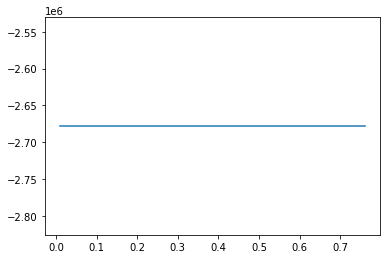

In [27]:
model_lasso=Lasso()
alpha=[]
error =[]

for i in range(1,100, 25):
    alpha.append(i/100)
    model_las=Lasso(alpha=(i/100))
    error.append(np.mean(cross_val_score(model_lasso,X_train,y_train,cv=3,scoring='neg_mean_absolute_error')))
plt.plot(alpha,error)

In [28]:
### Alpha doesnt affect mean cross validation socre, perhaps the model is not the right choice

# Ridge Regressor

## Baseline

In [29]:

model_rdg = Ridge(alpha=1, normalize=True)
model_rdg.fit(X_train, y_train)
prediction = model_rdg.predict(X_test)
mean_absolute_error(y_test,prediction)

2581448.0187913175

## Cross validation

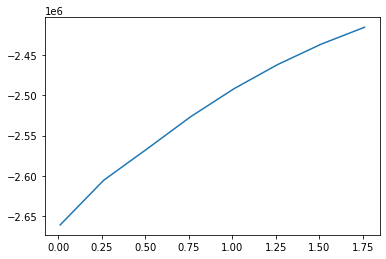

In [30]:
error=[]
alpha=[]

for i in range(1,200,25):
    model_rdg = Ridge(alpha=(i/100), normalize=True)
    alpha.append(i/100)
    error.append(np.mean(cross_val_score(model_rdg,X_train,y_train,cv=4,scoring='neg_mean_absolute_error')))
plt.plot(alpha,error)

# XGBoost

## Baseline

In [31]:
model_xgb = XGBRegressor(n_jobs=4)
model_xgb.fit(X_train, y_train)
prediction = model_xgb.predict(X_test)
mean_absolute_error(y_test,prediction)

1316206.2956399699

## Tuning

### Learning Rate

[0]	validation_0-rmse:14952635.00000
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:14897472.00000
[2]	validation_0-rmse:14845529.00000
[3]	validation_0-rmse:14798035.00000
[4]	validation_0-rmse:14750707.00000
[5]	validation_0-rmse:14704986.00000
[6]	validation_0-rmse:14655164.00000
[7]	validation_0-rmse:14611936.00000
[8]	validation_0-rmse:14568377.00000
[9]	validation_0-rmse:14526814.00000
[10]	validation_0-rmse:14485928.00000
[11]	validation_0-rmse:14445171.00000
[12]	validation_0-rmse:14406259.00000
[13]	validation_0-rmse:14367094.00000
[14]	validation_0-rmse:14328048.00000
[15]	validation_0-rmse:14293619.00000
[16]	validation_0-rmse:14257402.00000
[17]	validation_0-rmse:14222998.00000
[18]	validation_0-rmse:14188369.00000
[19]	validation_0-rmse:14157151.00000
[20]	validation_0-rmse:14123946.00000
[21]	validation_0-rmse:14079705.00000
[22]	validation_0-rmse:14041915.00000
[23]	validation_0-rmse:14005987.00000
[24]	validation_0-rmse:13970647.00

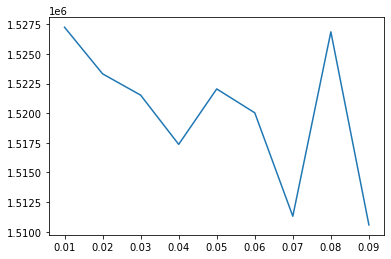

In [32]:
error = []
lr=[]
for x in range(1,10):
    
    model_xgb = XGBRegressor(n_jobs=4,learning_rate=(x/100))
    model_xgb.fit(X_train, y_train, 
                  early_stopping_rounds=5,
                 eval_set=[(X_test, y_test)],
                 verbose=True)
    prediction =model_xgb.predict(X_test)
    lr.append(x/100)
    error.append(mean_absolute_error(y_test,prediction))
plt.plot(lr,error)

### Rounds

In [33]:

model_xgb = XGBRegressor(n_estimators=1000,n_jobs=4,learning_rate=0.04)
model_xgb.fit(X_train, y_train, 
              eval_set=[(X_test, y_test)],
               verbose=False)
prediction =model_xgb.predict(X_test)
mean_absolute_error(y_test,prediction)

1205608.618731207

In [34]:
# save best model to pickle

In [35]:
pickl = {'model': model_rf}
pickle.dump( pickl, open( 'model_file' + ".p", "wb" ) )